In [ ]:
%pip install pandas numpy matplotlib seaborn statsmodels scikit-learn plotly openpyxl scipy 




  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached markupsafe-3.0.3-cp312-cp312-win_amd64.whl.metadata (2.8 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.30.0-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
   ---------------------------------------- 0.0/9.0 MB ? eta -:--:--
   -------- ------------------------------- 1.8/9.0 MB 12.6 MB/s eta 0:00:01
   ---------------- ----------------------- 3.7/9.0 MB 9.9 MB/s eta 0:00:01
   ---------------------- ----------------- 5.0/9.0 MB 7.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.3/9.0 MB 7.4 MB/s eta 0:00:01
   --------------------------------- ------ 7.6/9.0 MB 7.2 MB/s eta 0:00:01
   ---------------------------------------  8.9/9.0 MB 7.1 MB/s eta 0:00:01
   ------------------------------------

In [ ]:
# ==========================================
# 1. GLOBAL CONFIGURATION
# ==========================================
import os

# Define the paths to your files
# We use r"" (raw strings) to handle the backslashes in Windows paths correctly
curr_dir= os.getcwd()
base_file = os.path.join(curr_dir, "data", "transformed", "consolidated_all_hscodes.xlsx")
mapping_file = os.path.join(curr_dir, "data", "hscode", "cleaned_HS_Codes_for_processing.xlsx")

# Quick check to ensure files exist before proceeding
if os.path.exists(base_file) and os.path.exists(mapping_file):
    print("✅ Configuration Successful: Both files found.")
else:
    print("❌ Error: One or both files not found. Please check the paths above.")

✅ Configuration Successful: Both files found.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 2. LOAD & FILTER DATA
# ==========================================
print(f"Loading data from: {base_file} ...")

try:
    df = pd.read_excel(base_file)
    
    # Date Parsing: Converts 'Jan_2018' to a real DateTime object
    df['Date_Parsed'] = pd.to_datetime(df['Date'], format='%b-%Y')

    # --- 📉 APPLYING DATE FILTER ---
    cutoff_date = "2025-09-30"
    print(f"📉 Filtering Data: Keeping records only up to {cutoff_date}...")
    df = df[df['Date_Parsed'] <= cutoff_date]
    # -------------------------------

    print("✅ Data Loaded & Filtered Successfully.")
    print(f"Time Period: {df['Date_Parsed'].min().date()} to {df['Date_Parsed'].max().date()}")
    print(f"Total Rows: {len(df)}")
    
except Exception as e:
    print(f"❌ Error loading file: {e}")

Loading data from: C:\Users\Rahul\OneDrive - Indian Institute of Technology Indian School of Mines Dhanbad\ISM\Hackathons\Mineral processing\Final_files\Master_Critical_Mineral_Data.xlsx ...
📉 Filtering Data: Keeping records only up to 2025-09-30...
✅ Data Loaded & Filtered Successfully.
Time Period: 2017-01-01 to 2025-09-01
Total Rows: 112164


In [29]:
# ==========================================
# 3. DYNAMIC MINERAL MAPPING
# ==========================================
MINERAL_NAME_COL = "Element respective" # The column with 'Copper', 'Lithium', etc.

print(f"🔄 Loading HS Code Mapping from: {mapping_file} ...")

try:
    # 1. Load Mapping File
    map_df = pd.read_excel(mapping_file)
    map_df.columns = map_df.columns.str.strip() 
    
    # 2. Verify Columns
    if 'HSCode' not in map_df.columns or MINERAL_NAME_COL not in map_df.columns:
        raise ValueError(f"Columns 'HSCode' and '{MINERAL_NAME_COL}' must exist in the mapping file.")

    # 3. Create Dictionary & Map
    hs_code_map = dict(zip(map_df['HSCode'], map_df[MINERAL_NAME_COL]))
    print(f"✅ Loaded {len(hs_code_map)} HS Codes.")

    # 4. Apply to Main Data
    df['Mineral'] = df['HSCode'].map(hs_code_map)

    # 5. Clean & Sort
    df_clean = df[df['Mineral'].notna()].copy()
    df_clean = df_clean.sort_values(by=['Mineral', 'Date_Parsed'])

    print("✅ Categorization Complete.")
    print("Distribution of Minerals:")
    print(df_clean['Mineral'].value_counts())

except Exception as e:
    print(f"❌ Error in Mapping: {e}")

🔄 Loading HS Code Mapping from: C:\Users\Rahul\OneDrive - Indian Institute of Technology Indian School of Mines Dhanbad\ISM\Hackathons\Mineral processing\Final_files\hscodes_for_mineral_processing.xlsx ...
✅ Loaded 24 HS Codes.
✅ Categorization Complete.
Distribution of Minerals:
Mineral
Copper      74726
Graphite    27480
Lithium      9958
Name: count, dtype: int64


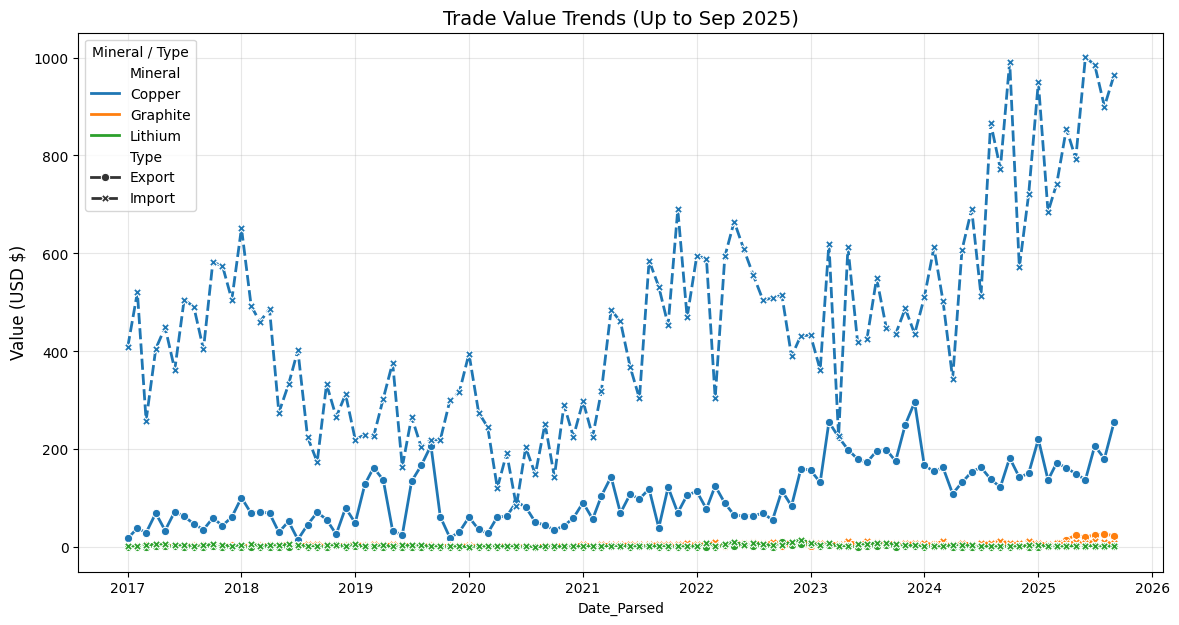


📊 Import Dependency Analysis (USD):


Type,Import,Export,Dependency_Ratio (%)
Mineral,,,
Copper,47982.76,11121.99,81.18
Graphite,683.36,473.31,59.08
Lithium,398.27,146.50,73.11


In [30]:
# ==========================================
# 4. STRATEGIC ANALYTICS (USD)
# ==========================================

# A. Visualizing Trade Trends
monthly_trend = df_clean.groupby(['Date_Parsed', 'Mineral', 'Type'])['Value'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.lineplot(data=monthly_trend, x='Date_Parsed', y='Value', hue='Mineral', style='Type', markers=True, linewidth=2)
plt.title(f"Trade Value Trends (Up to Sep 2025)", fontsize=14)
plt.ylabel("Value (USD $)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(title='Mineral / Type')
plt.show()

# B. Calculating Dependency Ratio
pivot_trade = df_clean.groupby(['Mineral', 'Type'])['Value'].sum().unstack().fillna(0)
pivot_trade['Total_Trade'] = pivot_trade.get('Import', 0) + pivot_trade.get('Export', 0)

pivot_trade['Dependency_Ratio (%)'] = np.where(
    pivot_trade['Total_Trade'] > 0,
    (pivot_trade.get('Import', 0) / pivot_trade['Total_Trade']) * 100,
    0
)

print("\n📊 Import Dependency Analysis (USD):")
display(pivot_trade[['Import', 'Export', 'Dependency_Ratio (%)']].round(2))

In [31]:
# ==========================================
# 5. STATISTICAL VALIDATION (ANOVA)
# ==========================================
from scipy.stats import f_oneway

print("🧪 Performing ANOVA Test...")

minerals_found = df_clean['Mineral'].unique()

if len(minerals_found) >= 2:
    groups = [df_clean[df_clean['Mineral'] == m]['Value'] for m in minerals_found]
    f_stat, p_val = f_oneway(*groups)

    print(f"F-Statistic: {f_stat:.2f}")
    print(f"P-Value: {p_val:.5f}")

    if p_val < 0.05:
        print("✅ Result: Significant difference exists between the trade values of these minerals.")
    else:
        print("⚠️ Result: No significant difference found.")
else:
    print("Insufficient minerals found for ANOVA.")

🧪 Performing ANOVA Test...
F-Statistic: 213.99
P-Value: 0.00000
✅ Result: Significant difference exists between the trade values of these minerals.



⚔️ Running Model Tournament for Copper...
   🏆 Winner: Holt-Winters Exp. Smoothing
   📉 RMSE: 167.52
   📊 MAPE: 15.92%


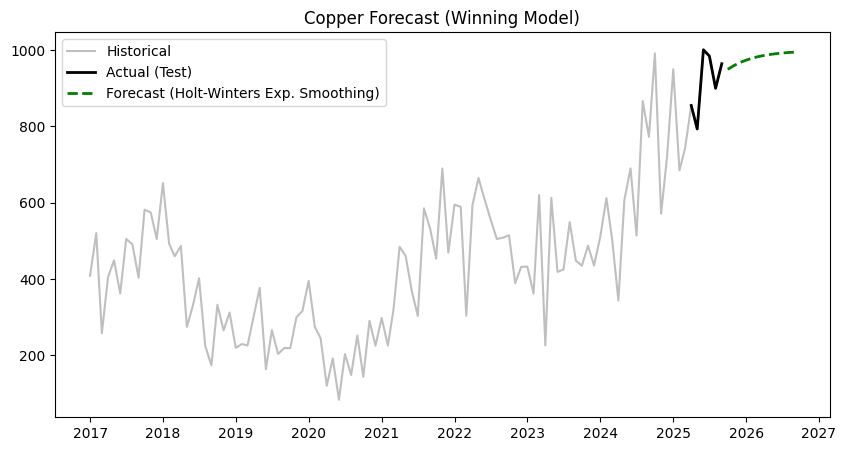


⚔️ Running Model Tournament for Graphite...
   🏆 Winner: Holt-Winters Exp. Smoothing
   📉 RMSE: 1.30
   📊 MAPE: 7.95%


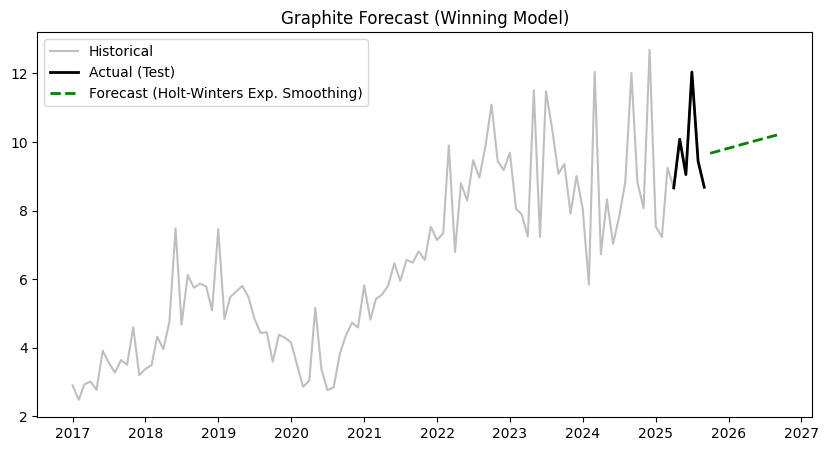


⚔️ Running Model Tournament for Lithium...
   🏆 Winner: Holt-Winters Exp. Smoothing
   📉 RMSE: 0.53
   📊 MAPE: 20.29%


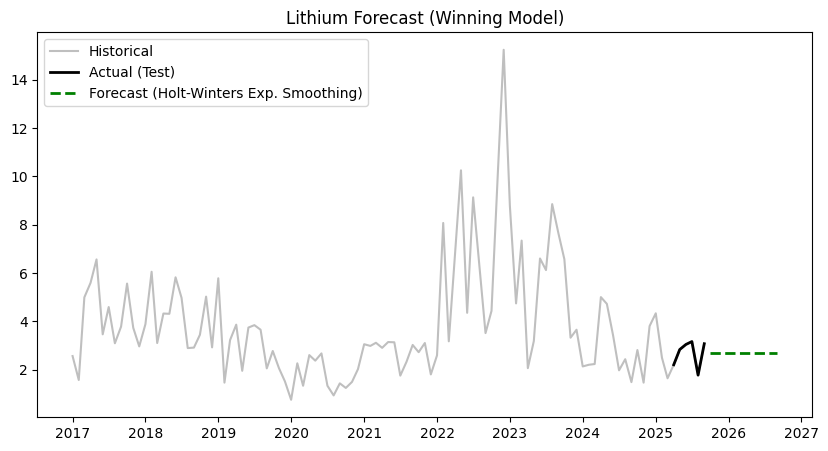

In [34]:
# ==========================================
# 6. ML FORECASTING (CHAMPION VS CHALLENGER)
# ==========================================
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

def train_tournament(mineral_name):
    print(f"\n⚔️ Running Model Tournament for {mineral_name}...")
    
    # 1. Prepare Data
    subset = df_clean[(df_clean['Mineral'] == mineral_name) & (df_clean['Type'] == 'Import')].copy()
    ts_data = subset.set_index('Date_Parsed')['Value'].resample('MS').sum().fillna(0)
    
    if len(ts_data) < 12:
        print("❌ Not enough data.")
        return

    # 2. Split Train/Test
    train = ts_data[:-6]
    test = ts_data[-6:]
    
    # --- MODEL A: ARIMA (The Stable Option) ---
    try:
        model_a = ARIMA(train, order=(5,1,0))
        fit_a = model_a.fit()
        pred_a = fit_a.forecast(steps=6)
        rmse_a = sqrt(mean_squared_error(test, pred_a))
    except:
        rmse_a = float('inf')
        
    # --- MODEL B: HOLT-WINTERS (The Volatility Handler) ---
    try:
        # Trend='add' assumes linear growth, Damped=True prevents unrealistic explosions
        model_b = ExponentialSmoothing(train, trend='add', seasonal=None, damped_trend=True)
        fit_b = model_b.fit()
        pred_b = fit_b.forecast(steps=6)
        rmse_b = sqrt(mean_squared_error(test, pred_b))
    except:
        rmse_b = float('inf')
    
    # 3. Pick the Winner
    if rmse_a < rmse_b:
        best_model_name = "ARIMA (5,1,0)"
        final_rmse = rmse_a
        winner_preds = pred_a
        
        # Retrain winner on FULL data
        final_model = ARIMA(ts_data, order=(5,1,0))
        final_fit = final_model.fit()
        future_forecast = final_fit.forecast(steps=12)
        
    else:
        best_model_name = "Holt-Winters Exp. Smoothing"
        final_rmse = rmse_b
        winner_preds = pred_b
        
        # Retrain winner on FULL data
        final_model = ExponentialSmoothing(ts_data, trend='add', seasonal=None, damped_trend=True)
        final_fit = final_model.fit()
        future_forecast = final_fit.forecast(steps=12)

    # 4. Calculate MAPE for the Winner
    non_zero_test = test[test != 0]
    non_zero_pred = winner_preds[test != 0]
    mape = (abs((non_zero_test - non_zero_pred) / non_zero_test).mean()) * 100 if len(non_zero_test) > 0 else 0.0

    # 5. Report Results
    print(f"   🏆 Winner: {best_model_name}")
    print(f"   📉 RMSE: {final_rmse:,.2f}")
    print(f"   📊 MAPE: {mape:.2f}%")
    
    # 6. Plot
    plt.figure(figsize=(10, 5))
    plt.plot(ts_data.index, ts_data, label='Historical', color='gray', alpha=0.5)
    plt.plot(test.index, test, label='Actual (Test)', color='black', linewidth=2)
    plt.plot(future_forecast.index, future_forecast, label=f'Forecast ({best_model_name})', color='green', linestyle='--', linewidth=2)
    plt.title(f"{mineral_name} Forecast (Winning Model)")
    plt.legend()
    plt.show()

# Run for all minerals
for m in df_clean['Mineral'].unique():
    train_tournament(m)